In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [12]:
import os
import collections
import itertools

In [13]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io as spio
import tensorflow as tf

In [14]:
% matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [15]:
from six.moves import urllib

In [16]:
print(np.__version__)
print(pd.__version__)
print(sp.__version__)
print(tf.__version__)

1.13.3
0.20.1
1.0.0
1.4.1


In [17]:
# The Stanford street view house numbers dataset is available here:
# http://ufldl.stanford.edu/housenumbers/

URL_TRAIN_PATH = "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
URL_TEST_PATH = "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"

DOWNLOADED_FILENAME_TRAIN = "housenumbers_training.mat"
DOWNLOADED_FILENAME_TEST = "housenumbers_test.mat"

def download_data():
    if not os.path.exists(DOWNLOADED_FILENAME_TRAIN):
        filename, _ = urllib.request.urlretrieve(URL_TRAIN_PATH, DOWNLOADED_FILENAME_TRAIN)

    print('Found and verified file from this path: ', URL_TRAIN_PATH)
    print('Downloaded file: ', DOWNLOADED_FILENAME_TRAIN)

    if not os.path.exists(DOWNLOADED_FILENAME_TEST):
        filename, _ = urllib.request.urlretrieve(URL_TEST_PATH, DOWNLOADED_FILENAME_TEST)

    print('Found and verified file from this path: ', URL_TEST_PATH)
    print('Downloaded file: ', DOWNLOADED_FILENAME_TEST)        

In [18]:
download_data()

Found and verified file from this path:  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Downloaded file:  housenumbers_training.mat
Found and verified file from this path:  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Downloaded file:  housenumbers_test.mat


In [19]:
train_mat = spio.loadmat(DOWNLOADED_FILENAME_TRAIN, squeeze_me=True)
test_mat = spio.loadmat(DOWNLOADED_FILENAME_TEST, squeeze_me=True)

In [20]:
type(train_mat)

dict

In [21]:
train_mat.keys()

['y', 'X', '__version__', '__header__', '__globals__']

In [65]:
x_train = train_mat['X']
y_train = train_mat['y']

x_test = test_mat['X']
y_test = test_mat['y']

In [66]:
x_train.shape

(32, 32, 3, 73257)

In [67]:
y_train.shape, y_test.shape

((73257,), (26032,))

In [68]:
x_train = np.transpose(x_train, (3, 0, 1, 2))

In [69]:
x_test = np.transpose(x_test, (3, 0, 1, 2))

In [70]:
x_train = x_train[:15000]
x_test = x_test[:1500]

y_train = y_train[:15000]
y_test = y_test[:1500]

In [71]:
x_train.shape

(15000, 32, 32, 3)

In [72]:
x_train[0].shape

(32, 32, 3)

In [73]:
def display_digit(digit):
    plt.imshow(digit, interpolation='nearest')

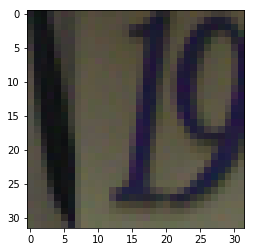

In [74]:
display_digit(x_train[0])

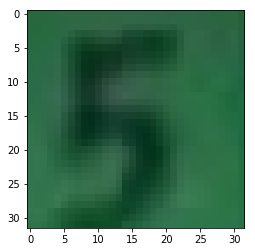

In [75]:
display_digit(x_test[0])

In [76]:
y_train[:5]

array([1, 9, 2, 3, 2], dtype=uint8)

In [77]:
height = 32
width = 32
channels = 3

n_inputs = height * width

In [78]:
conv1_feature_maps = 32
conv1_kernel_size = 3
conv1_stride = 1
conv1_pad = "SAME"

In [79]:
conv2_feature_maps = 64
conv2_kernel_size = 3
conv2_stride = 2
conv2_pad = "SAME"

In [80]:
pool3_feature_maps = conv2_feature_maps

In [81]:
n_fullyconn1 = 64
n_outputs = 11

In [82]:
tf.reset_default_graph()

In [83]:
X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")

In [84]:
y = tf.placeholder(tf.int32, shape=[None], name="y")

In [85]:
conv1 = tf.layers.conv2d(X, filters=conv1_feature_maps,
                         kernel_size=conv1_kernel_size,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")

In [86]:
conv1.shape

TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(32)])

In [87]:
conv2 = tf.layers.conv2d(conv1, filters=conv2_feature_maps, 
                         kernel_size=conv2_kernel_size,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

In [88]:
conv2.shape

TensorShape([Dimension(None), Dimension(16), Dimension(16), Dimension(64)])

In [89]:
pool3 = tf.nn.max_pool(conv2,
                       ksize=[1, 2, 2, 1],
                       strides=[1, 2, 2, 1],
                       padding="VALID")

In [90]:
pool3.shape

TensorShape([Dimension(None), Dimension(8), Dimension(8), Dimension(64)])

In [91]:
pool3_flat = tf.reshape(pool3, shape=[-1, pool3_feature_maps * 8 * 8])

In [92]:
fullyconn1 = tf.layers.dense(pool3_flat, n_fullyconn1,
                             activation=tf.nn.relu, name="fc1")

In [93]:
logits = tf.layers.dense(fullyconn1, n_outputs, name="output")

In [94]:
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,
                                                          labels=y)

In [95]:
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

In [96]:
correct = tf.nn.in_top_k(logits, y, 1)

In [97]:
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [98]:
init = tf.global_variables_initializer()

In [99]:
current_iteration = 0

def get_next_batch(batch_size):
    
    global current_iteration
    
    start_index = (current_iteration * batch_size) % len(y_train)
    end_index = start_index + batch_size

    x_batch = x_train[start_index: end_index]
    y_batch = y_train[start_index: end_index]

    current_iteration = current_iteration + 1

    return x_batch, y_batch

In [100]:
n_epochs = 10
batch_size = 100

In [101]:
with tf.Session() as sess:
    init.run()

    num_examples = len(y_train)
    for epoch in range(n_epochs):
        for iteration in range(num_examples // batch_size):

            X_batch, y_batch = get_next_batch(batch_size)

            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})

        acc_test = accuracy.eval(feed_dict={X: x_test, y: y_test})

        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)        

0 Train accuracy: 0.42 Test accuracy: 0.451333
1 Train accuracy: 0.67 Test accuracy: 0.645333
2 Train accuracy: 0.74 Test accuracy: 0.698
3 Train accuracy: 0.78 Test accuracy: 0.738667
4 Train accuracy: 0.85 Test accuracy: 0.754
5 Train accuracy: 0.8 Test accuracy: 0.741333
6 Train accuracy: 0.83 Test accuracy: 0.754
7 Train accuracy: 0.85 Test accuracy: 0.752
8 Train accuracy: 0.86 Test accuracy: 0.769333
9 Train accuracy: 0.82 Test accuracy: 0.764
